
Quantum Neural Network für die Regression einer einfachen Sinusfunktion
============================




Der folgende Code erzeugt ein einschichtiges QNN zur Regression einer einfachen Sinusfunktion. In der Arbeit wird er für die Regression in Kapitel 8.1 verwendet. Der erste Teil lädt alle nötigen Bibliotheken und initialisiert den IBM Quantum Account.





### Import der Bibliotheken





Der erste Teil lädt alle nötigen Bibliotheken und initialisiert den IBM Quantum Account.





In [1]:
# Math librarys
import numpy as np
import matplotlib.pyplot as plt
import random

# Librarys for IBM devices
from qiskit import *
from qiskit import IBMQ, assemble, transpile
from qiskit.providers.ibmq import least_busy

# Librarys for working with qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister
from qiskit.opflow import Z, I, StateFn
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitSampler, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from typing import Union
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

# Load the IBM Account
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')


<br/>

### Definition der Simulatoren und des Quantencomputers





Im zweiten Teil werden die Simulatoren und der Quantenprozessor für die Berechnung der Quantenschaltkreise vorbereitet.
<br/>- 'qi_sv' ist ein Simulator ohne Noise Modeling
<br/>- 'qi_qasm' ist ein Simulator mit Noise Modeling
<br/>- 'qi_real' ist ein Quantenprozessor.
<br/>Mit Hilfe der Funktion 'least_busy' wird der Quantenprozessor (mit <= 5 Qubits) gewählt, der im Moment am wenigsten Aufträge hat.





In [2]:
# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=250)

# define smallest devices to find least busy backend
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits <= 5
                                   and not x.configuration().simulator)

# create a QNN instance with a real quantum processor 
backend = least_busy(small_devices)
print(backend)

qi_real = QuantumInstance(backend, shots=250)


<br/>

### Definition der wichtigen Funktionen





Die folgende Zelle definiert alle wichtigen Funktionen, auf die im Code zurückgegriffen wird.
<br/>- 'callback_training()' wird während des Trainingsprozesses aufgerufen und zeichnet die Fehlerfunktion.
<br/>- 'evaluate_expectation()' berechnet den Erwartungswert eines Quantenschaltkreises bezogen auf die Observable 'Z'.
<br/>- 'evaluate_grad_finit_diff()' berechnet den Finit-Difference-Gradienten des erzeugten QNN und wird während des Trainings aufgerufen.
<br/>- 'root_square_loss()' berechnet den RMSE des erzeugten QNN in Bezug auf die Trainingsdaten
<br/>- 'loss_function()' handelt die Berechnung der Fehlerfunktion im Training der Netze.
<br/>- 'train_network()' stellt die Gesamtfunktion für das Training. Hier werden die einzelnen Trainingsschritte initialisiert und am Ende das optimierte Gewicht zurückgegeben. 
<br/>- 'root_square_loss' berechnet den RMSE des erzeugten QNN in Bezug auf die Trainingsdaten
<br/>- 'root_square_loss' berechnet den RMSE des erzeugten QNN in Bezug auf die Trainingsdaten
<br/>




In [3]:
# callback function that draws a live plot of the loss function and gets called by the training method
def callback_training(training_value):
    clear_output(wait=True)
    training_funct_vals.append(training_value)
    plt.title("Fehlerfunktion im Trainingsprozess")
    plt.xlabel("Iteration")
    plt.ylabel("Wert der Fehlerfunktion")
    plt.plot(range(len(training_funct_vals)), training_funct_vals)
    plt.show()

# Function to evaluate the expectation value of the quantum circuit. 
# The expectaton value represents the output of the QNN, with respect to
# a specific weight, an input x and an observable Z
def evaluate_expectation(weight,x):
    observable = Z                                                    # observable is the Pauli Z observable                  
    
    # the quantum circuit ('quantum_circuit') is the circuit, that was created by the serial_quantum_model() method
    # to represent the QNN
    expectation = StateFn(observable, is_measurement=True) @ StateFn(quantum_circuit)
    in_pauli_basis = PauliExpectation().convert(expectation)
    sampler = CircuitSampler(qnn_qi)
    
    weight_dict = [weight]
    weight_dict.append(x)
    
    value_dict = dict(zip(quantum_circuit.parameters, weight_dict))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

# Function to evaluate the finite difference gradient of a weight of the QNN
def evaluate_grad_finit_diff(weight):    
   
    # shift the parameter (weight) of the QNN by +- eps
    plus = weight
    minus = weight
    plus += eps
    minus -= eps
    
    # evaluate and return the finit difference gradient
    return (loss_function(plus) - loss_function(minus)) / (2 * eps)

# Calculate the RMSE of the QNN with respect to all the learning data 
def root_square_loss(weight):
    loss = 0
    predictions=[]
    # calculate the output of the QNN with the given weights for every input data in X_learn
    for i in range(X_learn.size):
        predictions.append(evaluate_expectation(weight,X_learn[i]))
    # sum up the squared difference between QNN predictions and the corresponding learning output y_learn
    for t, p in zip(y_learn, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(y_learn)
    return np.sqrt(loss)

def loss_function(weight):
    loss = 0
    predictions=[]
    # check, wether the batch size is smaller then the number of total learning examples
    if size_batch>num_samples:
        raise ValueError('Batch size is bigger then the number of learning examples!')
    
    # form a batch of learning values, randomly picked out of X_learn 
    batch_indices = random.sample(range(0, X_learn.size), size_batch)
    batch = [X_learn[l] for l in batch_indices]
    y_batch = [y_learn[k] for k in batch_indices]
    # calculate the output of the QNN with the given weights for the batch data
    for i in range(size_batch):
        predictions.append(evaluate_expectation(weight,batch[i]))
    # sum up the squared difference between QNN predictions and the corresponding learning output
    for t, p in zip(y_batch, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(batch)
    return 0.5*loss
    

def train_network(weights):
    # Prepare the lists and arrays
    weight_training = weights                                                 # take the starting weights from the function argument 
    gradient = 0.0                                                            # list for gradients
    delta = 0.0                                                               # list for the updates of the weights
    X_learning_steps = np.full([learning_steps], range(learning_steps))       # list with the leaning steps
    RMSE_training = np.full([learning_steps], 0.0)                            # list for the RMSE after every training step
     
    # Train the weight
    for j in range(learning_steps):
        gradient = evaluate_grad_finit_diff(weight_training)
        delta = -gradient*learning_rate
        weight_training += delta
        RMSE_training[j] = root_square_loss(weight_training)                 # calculate the RMSE after every learning step
        callback_training(RMSE_training[j])                                  # call the function to plot the RMSE
        
    return weight_training


<br/>

### Erzeugung des Quantenschaltkreises





Die Zelle unten erzeugten den parametrisierten Quantenschaltkreis, welcher das QNN repräsentiert. Dabei codieren zwei Ry-Gatter den Input und das Gewicht des QNN. Der Schaltkreis ist in der Variablen 'quantum_circuit' gespeichert.
<br/>




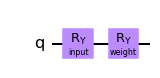

In [4]:
## BUILD THE QUANTUM CIRCUIT FOR THE QNN ##
# Construct the circuit for the QNN with parallel architecture 
parameters = [Parameter("input"), Parameter("weight")]  # parameter, that will represent the input and the weight in the circuit
quantum_circuit = QuantumCircuit(1)
quantum_circuit.ry(parameters[0],0)                     # parametrized Ry-Rotation Gate with input as parameter
quantum_circuit.ry(parameters[1],0)                     # parametrized Ry-Rotation Gate with weight as parameter

# draw the quantum circuit
quantum_circuit.draw('mpl')


<br/>

### Erzeugung der Trainingsdaten





Nachfolgend werden die Lern- und Testdaten für die Regression erzeugt. Es muss angemerkt werden, dass die Testdaten aus dem Extrapolationsbereich bei der Regression der Sinusfunktion noch nicht zum Einsatz kommen, deshalb ist der Extrapolationsraum identisch mit dem Lernbereich. Außerdem werden die Lerndaten und die für die Erzeugung verwendete Sinusfunktion geplottet.
<br/>- 'X_learn' und 'y_learn' enthalten die Trainingsdaten- 'X_apply' und 'y_apply' enthalten die Testdaten aus dem Extrapolationsraum




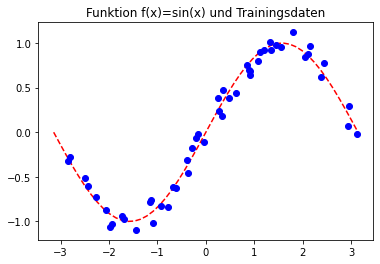

In [6]:
num_samples = 50
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50)

## LERNBEREICH ## 
x_learn_min = -np.pi
x_learn_max = np.pi

## ANWENDUNGSBEREICH ##
x_apply_min = -np.pi
x_apply_max = np.pi


#Sinus
f = lambda x: np.sin(x)

#Glockenkurve
#f = lambda x: 1/np.exp(x**2)

#Gerade
#f = lambda x: x/np.pi

X_learn = np.random.uniform(x_learn_min, x_learn_max, num_samples)
X_apply = np.random.uniform(x_apply_min, x_apply_max, num_samples)
y_learn = np.array([f(x_)+(random.uniform(-0.15,0.15)) for x_ in X_learn])
y_apply = f(X_apply)

plt.plot(X_, f(X_), "r--")
plt.plot(X_learn, y_learn, "bo")
plt.title("Funktion f(x)=sin(x) und Trainingsdaten")
plt.show()


<br/>

### Initialisierung des QNN





Das Gewicht des QNN wird per Zufall initialisiert. Außerdem wird über die Variable 'qnn_qi' eine Berechnungsinstanz von oben zur Berechnung der Quantenschaltkreise gewählt. Anschließend wird der RMSE des initialisierten QNN in Bezug auf die Trainingsdaten berechnet und die Funktion des QNN geplottet.
<br/>




RMSE no training: 1.2764714326189817


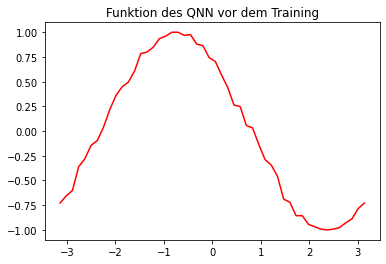

In [12]:
## parameters of training ##
starting_weight = np.random.uniform(0,2*np.pi)

# choose, which Quantum Instance will be used to calculate expectation values:
#qi_sv   = state vector based evaluation (no noise)
#qi_qasm = simulator based evaluation (noise simulation)
#qi_real = execution on real quantum processor
qnn_qi = qi_qasm

#calculate RMSE
RMSE_notraining = root_square_loss(starting_weight)

#print(RMSE_notraining)
print('RMSE no training:', RMSE_notraining)

# plot network-function without training
y_notraining = [evaluate_expectation(starting_weight,x_) for x_ in X_]
plt.plot(X_, y_notraining, "r-")
plt.title("Funktion des QNN vor dem Training")
plt.show()


<br/>

### Training des Netzes





Hier findet das Training des QNN statt. Über die Funktion 'train_network()' (siehe Zelle oben) wird das optimierte Gewicht berechnet und ausgegeben. Weiterhin wird der RMSE nach dem Training in Bezug auf die Trainingsdaten ausgegeben.
<br/>




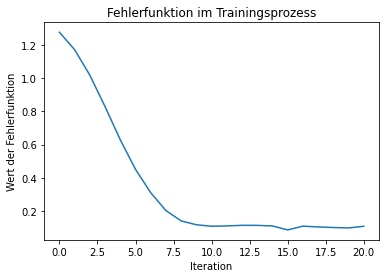

RMSE simulation (after training):  0.10882509811744508


In [13]:
## Train the Network ##
eps = 0.35                              # parameter for the Gradients
learning_rate = 0.8                    # learning rate for the weights of the network
learning_steps = 20                    # number of learning steps durign training
size_batch = 50                        # number of learning examples to compute the loss function

# Prepare the callback function to plot the training progress
training_funct_vals = []

# Plot the RMSE before training into the diagram
callback_training(RMSE_notraining)

# Train the network and get the optimized weight
opt_weight = train_network(starting_weight)

    
# Calculate final RMSE with apply action
RMSE_simulation = root_square_loss(opt_weight)
print('RMSE simulation (after training): ', RMSE_simulation) 


<br/>

### Plot Trainingsergebnis





Abschließend wird die trainierte Funktion des QNN (grüne Linie) mit den Trainingsdaten und der Sinusfunktion geplottet.
<br/>




Final loss:  0.10415403188868162


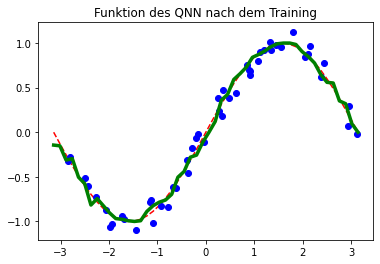

In [14]:
# Calculate final RMSE with apply action

print('Final loss: ', root_square_loss(opt_weight))

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X_learn, y_learn, "bo")

# plot fitted line
#Netzwerkfunktion
#f_NN = lambda x: evaluate_expectation(opt_weight,x)
y_NN = [evaluate_expectation(opt_weight,x_) for x_ in X_]
plt.title("Funktion des QNN nach dem Training")
plt.plot(X_, y_NN, "g-",  linewidth=3.5)
plt.show()